## In-class hands-on activity: Tree-based Methods

### Credit Card Fraud Prediction
Original dataset from <https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data>

走過下面的的Cell, 依序執行。下面有些Cell中標明"TODO"。請依照說明完成這些函數或程式片段，讓整個檔案能正確的執行。

課程名稱: 統計學習與深度學習。

### 資料說明 (From Kaggle)

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

### TL;DR

* 任務是預測欺詐交易。
* 資料中Positive (欺詐) Record有492筆，只佔0.172%，有Data Imbalance的問題。 (一般Positive Records小於10%就可能會有Data Imbalance的問題; 小於1%都算嚴重的Data Imbalance。)
* 因為保護個資的原因，不提供變數名稱與意義。
* 因為Data Imbalance的原因，建議使用Area Under the Precision-Recall Curve (AUPRC)衡量預測力。AUPRC可以視為F-score的延伸。sklearn實做是sklearn.metrics.average_precision_score()。
* Data Imbalance的處理方法有很多，最簡單的作法使用Under Sampling (negative examples)。雖有更複雜的作法，如SMOTE，但不一定總是有幫助，只能Case-by-Case的嘗試。

範例Precision-Recall Curve:

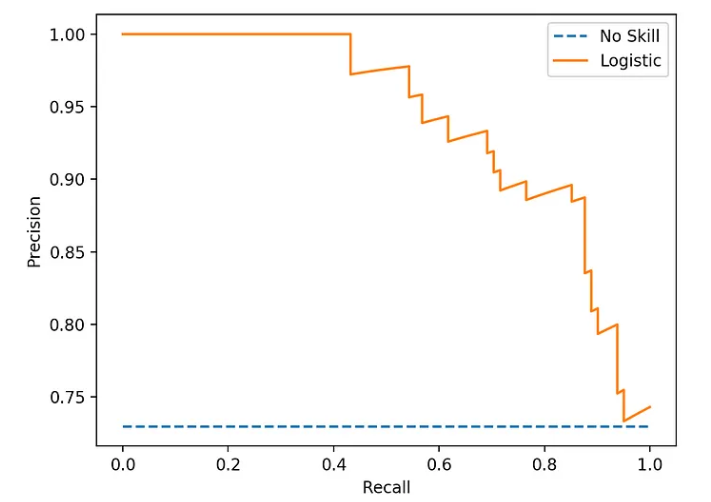

---
### 資料讀取與初步探索

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.utils import check_random_state
warnings.filterwarnings("ignore")

### Fix the randomness!
1. Execute the below cell to fix randomness in this notebook.
2. **For every sklearn models, fix random_state to RND_SEED!!!**


For example:
```python
LogisticRegressionCV(random_state=RND_SEED)
```

In [2]:
RND_SEED = 1243
os.environ["PYTHONHASHSEED"] = str(RND_SEED)
random.seed(RND_SEED)
np.random.seed(RND_SEED)
np.random.set_state(np.random.RandomState(RND_SEED).get_state())
sklearn_random_state = check_random_state(RND_SEED)

In [3]:
df = pd.read_csv('./creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


注意Class是我們的Label。

---

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


觀察:
* Class Mean 是 0.001727，與上面的描述一致。
* Time 應該是秒數之類的東西。看來是線性的。
* V1 - V28 均數都接近0。標準差大致上介於 1.6 - 0.3之間。後面的變數標準差較小。
* Amount 均數88.3, 標準差250。後續也許需要標準化。

### 檢查缺值

In [5]:
df.isnull().sum().max()

0

### 確認Data Imbalance狀況

In [6]:
print(f'No Frauds {round(df["Class"].value_counts()[0]/len(df) * 100,2)}% of the dataset')
print(f'Frauds {round(df["Class"].value_counts()[1]/len(df) * 100,2)}% of the dataset')

No Frauds 99.83% of the dataset
Frauds 0.17% of the dataset


### 好奇瞭解一下Amount的分布
* 看來Amount非常Skew。
* 時間上有兩群，猜測是兩天的資料。

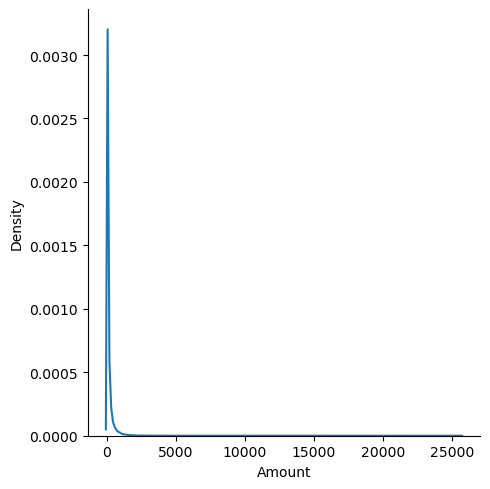

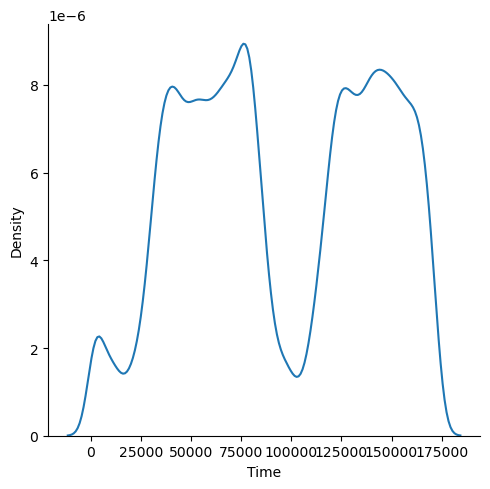

In [7]:
sns.displot(data=df, x='Amount', kind="kde")
sns.displot(data=df, x='Time', kind="kde")

### Feature Transformation

* 將Amount轉成Quantile
* 時間則使用Standardization

In [8]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer

qtran = QuantileTransformer()
sscalar = StandardScaler()

df['scaled_amount'] = qtran.fit_transform(df['Amount'].values.reshape((-1, 1)))
df['scaled_time'] = sscalar.fit_transform(df['Time'].values.reshape((-1, 1)))

In [9]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,0.028028,1.641931
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,0.512825,1.641952
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,0.719665,1.641974
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,0.345846,1.641974
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0,0.903892,1.642058


### 資料切割

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop(['Class', 'Amount', 'Time'], axis=1)
y = df['Class']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RND_SEED)
split_index = sss.split(X, y)
# to simplify the routine; we only take the first split to generate training and test data
train_index, test_index = next(split_index)

Xtrain_orig, Xtest_orig = X.iloc[train_index], X.iloc[test_index]
ytrain_orig, ytest_orig = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
Xtrain_orig = Xtrain_orig.values
Xtest_orig = Xtest_orig.values
ytrain_orig = ytrain_orig.values
ytest_orig = ytest_orig.values

In [11]:
# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(ytrain_orig, return_counts=True)
test_unique_label, test_counts_label = np.unique(ytest_orig, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(ytrain_orig))
print(test_counts_label/ len(ytest_orig))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827173 0.00172827]
[0.99827955 0.00172045]


### Undersampling for Negative Examples

Undersampling negative example 可以讓負例的作用減少。這對某些方法有幫助。但減少訓練資料其實是一件有害的事情。任何減少訓練資料的決定都應該要三思。

In [12]:
pnratio = 50
npos_orig = np.sum(ytrain_orig)
print(f"Original positive case number = {npos_orig}")
nneg_us = npos_orig * pnratio
print(f"negative case after undersample = {nneg_us}")

Original positive case number = 443
negative case after undersample = 22150


In [13]:
np.sum(ytrain_orig)

443

In [14]:
# keep all positive examples and do a under sample for negative examples

pind = np.argwhere(ytrain_orig > 0)
pind = pind.flatten()
nind = np.argwhere(ytrain_orig == 0)
nindsub = nind[0:nneg_us, 0]
ind_us = np.concatenate((pind, nindsub))
np.random.shuffle(ind_us)
train_index_us = train_index[ind_us]

Xtrain_us = X.iloc[train_index_us]
ytrain_us = y.iloc[train_index_us]

In [15]:
np.sum(ytrain_us)

443

### Visualization

Visualize X_train_us and y_train_us using t-SNE and PCA. Set random_state=RND_SEED when calling TSNE and PCA so that the results can be compared. 

PCA time: 0.01s, t-SNE time: 57.37s


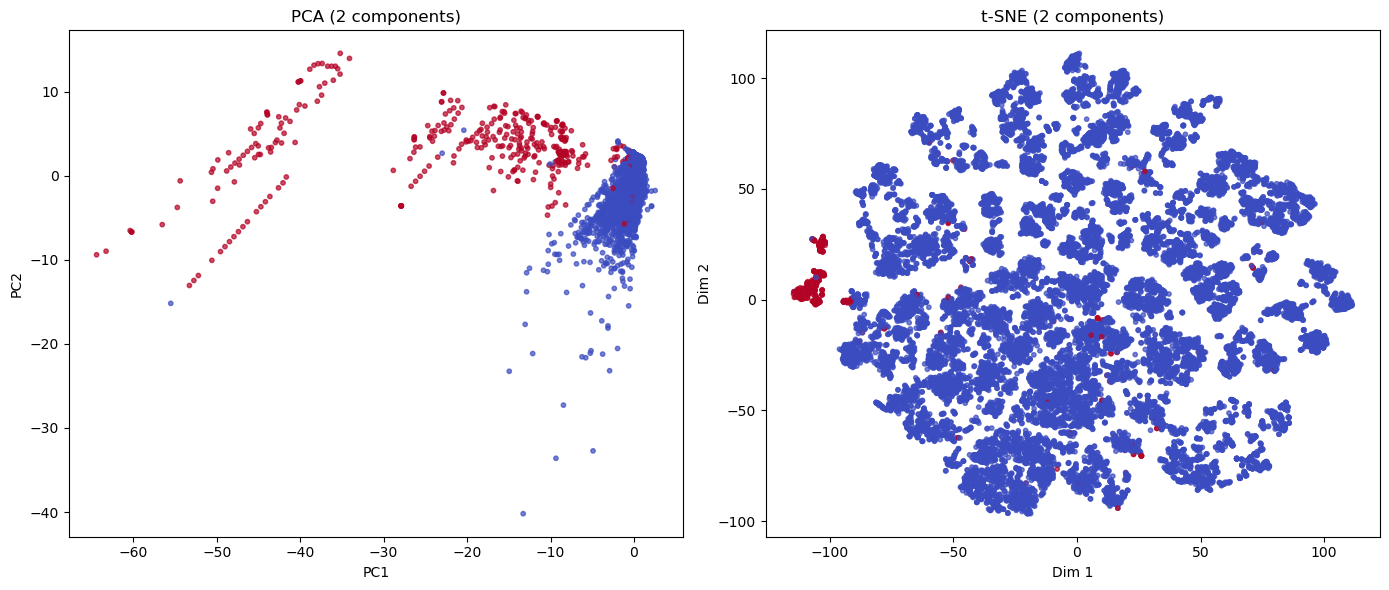

CPU times: user 3min 44s, sys: 6.78 s, total: 3min 51s
Wall time: 57.8 s


In [17]:
%%time

import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# TODO 1
# Ensure inputs are numpy arrays
Xus = Xtrain_us.values if hasattr(Xtrain_us, "values") else Xtrain_us
yus = ytrain_us.values if hasattr(ytrain_us, "values") else ytrain_us

# PCA 2 components
t0 = time.time()
pca = PCA(n_components=2, random_state=RND_SEED)
X_pca = pca.fit_transform(Xus)
t_pca = time.time() - t0

# t-SNE 2 components
t0 = time.time()
tsne = TSNE(n_components=2, random_state=RND_SEED, perplexity=30, max_iter=1000, init='pca')
X_tsne = tsne.fit_transform(Xus)
t_tsne = time.time() - t0

print(f"PCA time: {t_pca:.2f}s, t-SNE time: {t_tsne:.2f}s")

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14,6))
scatter = axes[0].scatter(X_pca[:,0], X_pca[:,1], c=yus, cmap='coolwarm', s=10, alpha=0.7)
axes[0].set_title('PCA (2 components)')
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')

axes[1].scatter(X_tsne[:,0], X_tsne[:,1], c=yus, cmap='coolwarm', s=10, alpha=0.7)
axes[1].set_title('t-SNE (2 components)')
axes[1].set_xlabel('Dim 1'); axes[1].set_ylabel('Dim 2')

plt.tight_layout()
plt.show()


### Sanity Check

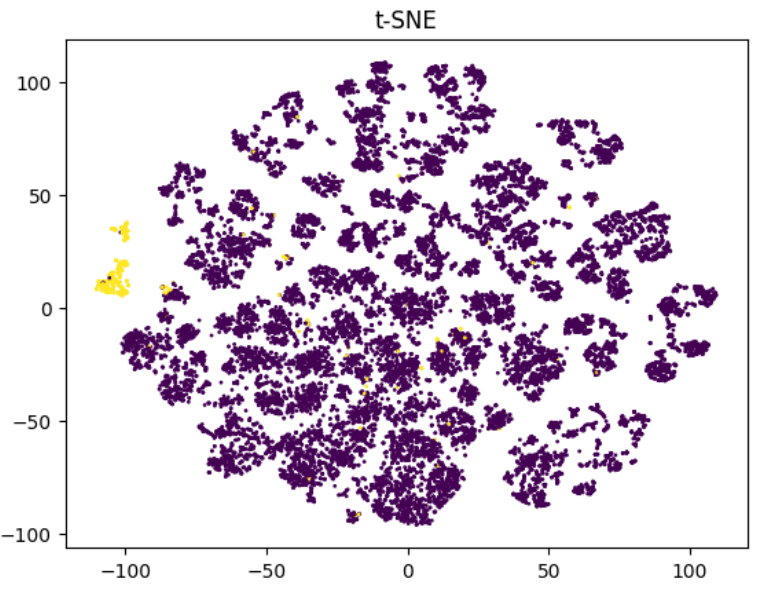

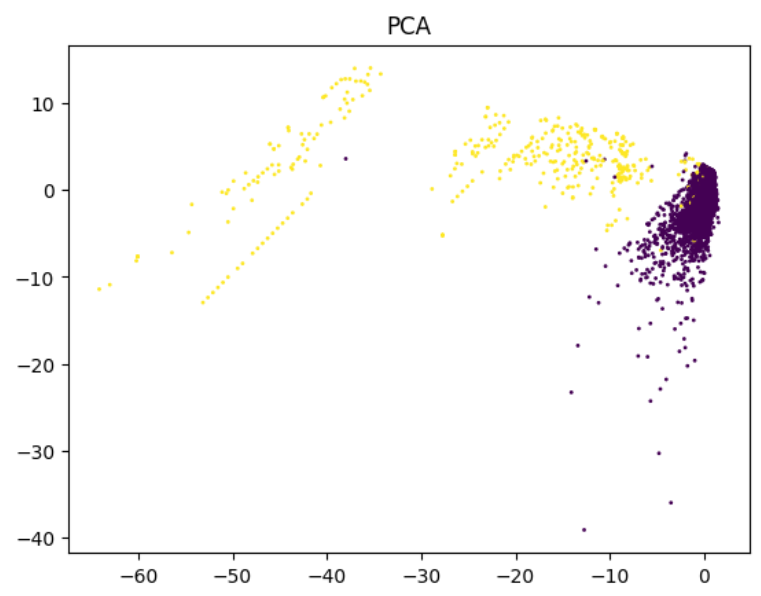

## Some Observations

請觀察視覺化結果，說明其與後續預測模型建模間的關係。更具體一點說，這兩張圖片讓你對預測模型有良好結果更有信心或更沒信心? 為什麼?



### Prediction Models

Start with Logistic Regression as the baseline. 

Train logistic regression on the full training dataset and the under-sampled dataset. Test on the test set. Compare the performance and state your observation. Note that the two models should test on exactly the same test set. 

In [18]:
from sklearn import linear_model
from sklearn import metrics

lrc = linear_model.LogisticRegressionCV(random_state=RND_SEED)
lrc.fit(Xtrain_orig, ytrain_orig)
print(f"[Using all training data] The regularization coefficient is {lrc.C_[0]:.4f}")
ypred_lr=lrc.predict(Xtest_orig)

aps0 = metrics.average_precision_score(ytest_orig, ypred_lr)
print(f"[Using all training data] Average Precision Score is {aps0:.4f}")
f1 = metrics.f1_score(ytest_orig, ypred_lr)
print(f"[Using all training data] F1 score is {f1:.4f}")
print("---")

# TODO 2
# Do the same using under-sampled data
# Convert to arrays if needed
X_train_us_arr = Xtrain_us.values if hasattr(Xtrain_us, "values") else Xtrain_us
y_train_us_arr = ytrain_us.values if hasattr(ytrain_us, "values") else ytrain_us

lrc_us = linear_model.LogisticRegressionCV(random_state=RND_SEED, cv=5, max_iter=1000)
lrc_us.fit(X_train_us_arr, y_train_us_arr)
print(f"[Using under-sampled training data] The regularization coefficient is {lrc_us.C_[0]:.4f}")

ypred_lr_us = lrc_us.predict(Xtest_orig)
aps_us = metrics.average_precision_score(ytest_orig, ypred_lr_us)
f1_us = metrics.f1_score(ytest_orig, ypred_lr_us)
print(f"[Using under-sampled training data] Average Precision Score is {aps_us:.4f}")
print(f"[Using under-sampled training data] F1 score is {f1_us:.4f}")

[Using all training data] The regularization coefficient is 0.3594
[Using all training data] Average Precision Score is 0.5371
[Using all training data] F1 score is 0.7160
---
[Using under-sampled training data] The regularization coefficient is 0.3594
[Using under-sampled training data] Average Precision Score is 0.6667
[Using under-sampled training data] F1 score is 0.8163


### Sanity Check
<pre>
[Using all training data] The regularization coefficient is 0.3594
[Using all training data] Average Precision Score is 0.5371
[Using all training data] F1 score is 0.7160
---
[Using under-sampled training data] The regularization coefficient is 0.3594
[Using under-sampled training data] Average Precision Score is 0.6667
[Using under-sampled training data] F1 score is 0.8163
</pre>

### Observations

### --- Remove Below ---

It is clear that training using under-sampled data produce better test performance. Interestingly, the regularization coefficient picked by CV are exactly the same. 

The result confirmed the traditional wisdom that under-sampling is effective for logistic regression. 
### --- Remove Above ---

### Decision Tree Classifier

先考慮沒有任何Regularization的狀況。
Train a DecisionTreeClassifier and report average precision score and F1 score

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# TODO 3
tree_noreg = DecisionTreeClassifier(random_state=RND_SEED)
tree_noreg.fit(Xtrain_orig, ytrain_orig)
ypred_tree = tree_noreg.predict(Xtest_orig)

aps_tree = metrics.average_precision_score(ytest_orig, ypred_tree)
f1_tree = metrics.f1_score(ytest_orig, ypred_tree)
print(f"Average Precision Score is {aps_tree:.4f}")
print(f"F1 score is {f1_tree:.4f}")

Average Precision Score is 0.5898
F1 score is 0.7677


### Sanity Check
<pre>
Average Precision Score is 0.5898
F1 score is 0.7677
</pre>



接下來嘗試Cost-complexity pruning的作法。
使用GridSearchCV 搭配`tree_params = {"ccp_alpha": [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}` 找出最好的alpha。


In [20]:

tree_params = {"ccp_alpha": [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, 
                         scoring="f1", n_jobs=6)
grid_tree.fit(Xtrain_orig, ytrain_orig)

print(grid_tree.best_params_)
# tree best estimator
tree_clf = grid_tree.best_estimator_


{'ccp_alpha': 1e-05}


### Sanity Check
<pre>
{'ccp_alpha': 1e-05}    
</pre>
    

雖然接下來可以直接使用tree_clf (上面利用GridSearchCV 找出的最佳tree), 但這個模型只使用了部分訓練資料。我們把所有訓練資料拿來重新訓練這個模型，之後再對測試資料預測。

### TODO

In [21]:
# TODO 4
best_alpha = grid_tree.best_params_.get('ccp_alpha', None) if 'grid_tree' in globals() else None
# If grid_tree is not in scope, you can set best_alpha = 1e-5 based on earlier sanity check.
if best_alpha is None:
    best_alpha = 1e-5

tree_retrained = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=RND_SEED)
tree_retrained.fit(Xtrain_orig, ytrain_orig)
ypred_tree_retrained = tree_retrained.predict(Xtest_orig)

aps_tree_retrained = metrics.average_precision_score(ytest_orig, ypred_tree_retrained)
f1_tree_retrained = metrics.f1_score(ytest_orig, ypred_tree_retrained)
print(f"Average Precision Score is {aps_tree_retrained:.4f}")
print(f"F1 score is {f1_tree_retrained:.4f}")

Average Precision Score is 0.6989
F1 score is 0.8315


### Sanity Check
<pre>
Average Precision Score is 0.6989
F1 score is 0.8315    
</pre>

接下來使用Under-sampling Data 重複alpha 的估計與模型評估。
### TODO

In [22]:
# TODO 5
# Run GridSearchCV on undersampled training data
grid_tree_us = GridSearchCV(DecisionTreeClassifier(random_state=RND_SEED), tree_params, scoring="f1", n_jobs=6, cv=5)
grid_tree_us.fit(Xtrain_us, ytrain_us)

print("Under-sampled data training (test alpha):", grid_tree_us.best_params_)
best_alpha_us = grid_tree_us.best_params_.get('ccp_alpha', 0.0)

# Retrain on the whole undersampled training set with best alpha
tree_us_retrained = DecisionTreeClassifier(ccp_alpha=best_alpha_us, random_state=RND_SEED)
tree_us_retrained.fit(Xtrain_us, ytrain_us)

ypred_tree_us = tree_us_retrained.predict(Xtest_orig)
aps_tree_us = metrics.average_precision_score(ytest_orig, ypred_tree_us)
f1_tree_us = metrics.f1_score(ytest_orig, ypred_tree_us)
print(f"[Under-sampled data] Average Precision Score is {aps_tree_us:.4f}")
print(f"[Under-sampled data] F1 score is {f1_tree_us:.4f}")

Under-sampled data training (test alpha): {'ccp_alpha': 0.0001}
[Under-sampled data] Average Precision Score is 0.5201
[Under-sampled data] F1 score is 0.7130


### Sanity Check
<pre>
Under-sampled data training (test alpha): {'ccp_alpha': 1e-05}
[Under-sampled data] Average Precision Score is 0.5201
[Under-sampled data] F1 score is 0.7130
</pre>


### 我的觀察 (TODO 6)



1. 使用 under-sampling 訓練的 Logistic Regression 在測試集上通常得到較高的 F1 與 AUPRC，原因是模型在訓練時較多機會學到 positive 的特徵，避免完全被 negative 壓過。但 under-sampling 會捨棄大量資料，可能導致資訊流失與泛化能力下降。
2. 對於 Decision Tree，未修剪 no regularization 的樹容易 overfit。使用 cost-complexity pruning 通常可以提升在測試集的穩定性與表現。